In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'real-and-fake-news-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F402856%2F772680%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240312%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240312T111747Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc3227465d383492a68ffacb6962a1b711cd9e47e0bb3aefd61f40805e4bc1759a97ff81b22a5634a0b92c6f5da132d61130244f28b0f2eb2d529ebc88b470acfb2a743f6e4cee30f1be66b61e919f6b920e006d2c1959fc91e9324fb04a8d39cb497cad182d45f0d9b8698988521a6f01641b84b05b72373fb5feae6f97f018506b394e200a2b2f36ad09a4e1dc78e475018e0dee3c0e02b5467cda309f491555d64c93e1f959bdeeb47fca25bd159f8873a0145df4583397816977b048ee99f5b2f090c5af0ebbca30e7f8d6a7daeccc9611983722e120e811ee4b2eea56d72ae408284e0e8e2ae358bb6130273e0b09489df4ad3e26021fe69800d2a2bfa8e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
data = pd.read_csv('news.csv')
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


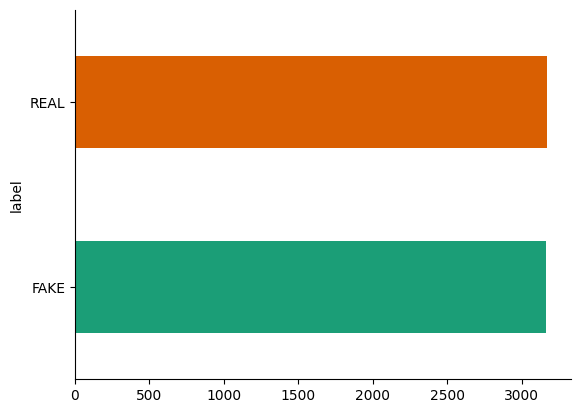

In [2]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
#looks like we have a balanced dataset

In [15]:
data.shape

(6335, 4)

In [18]:
data["title"].nunique()

6256

In [48]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_label = encoder.fit_transform(data["label"])

In [75]:
from keras.utils import to_categorical

# Assuming y_label is the original label data
y_label_encoded = to_categorical(y_label, num_classes=2)

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Remove Stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]


    return " ".join(tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Arvin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arvin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data["title"] = data["title"].apply(preprocess_text)

In [108]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Embedding, GRU, Dropout, Bidirectional, SpatialDropout1D, Conv1D, BatchNormalization, Input, AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [7]:
tokenizer = Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890',
    lower=True,
    split=' ',
    char_level=False,
    oov_token="<oov>",
    analyzer=None,
)
title = data["title"]
tokenizer.fit_on_texts(title)
X_title = tokenizer.texts_to_sequences(title)
X_title_paded = pad_sequences(X_title, maxlen=100, dtype='int32', padding='pre', truncating='post', value=0.0)


In [22]:
vocab_size = len(tokenizer.word_index) + 1

7457

In [156]:
def model_gen(pre_trained_embd, pre_trained_embd_layer, embedding_input, embedding_output, lstm_layers, lstm_units, dense_layers, dense_units, output_classes, input_length, conv_layers, conv_units):
    if not pre_trained_embd:
        input = Input(shape=(input_length,))
        x = Embedding(embedding_input, embedding_output)(input)
        # Add SpatialDropout1D layer
        x = SpatialDropout1D(0.3)(x)
    else:
        input = Input(shape=(), dtype=tf.string)
        x = pre_trained_embd_layer(input)
    
    
    # Add Conv1D layers based on the input parameters
    for i in range(conv_layers):
        x = Conv1D(filters=conv_units, kernel_size=4, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = AveragePooling1D(pool_size=2)(x)
    
    # Add LSTM layers and dropout based on the input parameters
    for i in range(lstm_layers):
        x = Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(x)
        x = BatchNormalization()(x)
    
    x = Bidirectional(GRU(32, dropout=0.6, recurrent_dropout=0.5))(x)
    x = BatchNormalization()(x)
    x = Bidirectional(GRU(16, dropout=0.5, recurrent_dropout=0.5))(x)
    x = BatchNormalization()(x)
    
    # Add Dense layers, dropout and batch normalization based on the input parameters
    for i in range(dense_layers):
        x = Dense(dense_units, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.6)(x)
    
    output = Dense(output_classes, activation='sigmoid')(x)
    
    model = Model(inputs=input, outputs=output)
    return model
    


In [130]:
import tensorflow as tf
tf.keras.backend.clear_session()
#Define the model and compiling 
model_with_title = model_gen(
    embedding_input=vocab_size, 
    embedding_output=64, 
    lstm_layers=1, 
    lstm_units=32, 
    dense_layers=1, 
    dense_units=32, 
    output_classes=2, 
    input_length=100, 
    conv_layers=1, 
    conv_units=32)

model_with_title.compile(optimizer=Adam(learning_rate=0.0004), loss='binary_crossentropy', metrics=['accuracy'])
model_with_title.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 64)           477248    
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 64)           0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           8224      
                                                                 
 batch_normalization (Batch  (None, 100, 32)           128       
 Normalization)                                                  
                                                                 
 average_pooling1d (Average  (None, 50, 32)            0     

In [131]:
from tensorflow.keras.callbacks import LearningRateScheduler
# Define the learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * np.exp(-0.1)
    
# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)


In [132]:
#Now we fit the model
history = model_with_title.fit(X_title_paded, y_label_encoded, epochs=20, batch_size=64, validation_split=0.16)

Epoch 1/20
84/84 [==============================] - 39s 229ms/step - loss: 1.0395 - accuracy: 0.5052 - val_loss: 0.7187 - val_accuracy: 0.4763
Epoch 2/20
84/84 [==============================] - 20s 245ms/step - loss: 0.9409 - accuracy: 0.5215 - val_loss: 0.7523 - val_accuracy: 0.4763
Epoch 3/20
84/84 [==============================] - 20s 240ms/step - loss: 0.8443 - accuracy: 0.5640 - val_loss: 0.7320 - val_accuracy: 0.4763
Epoch 4/20
84/84 [==============================] - 21s 245ms/step - loss: 0.7160 - accuracy: 0.6659 - val_loss: 0.6549 - val_accuracy: 0.5710
Epoch 5/20
84/84 [==============================] - 21s 251ms/step - loss: 0.5811 - accuracy: 0.7559 - val_loss: 0.5034 - val_accuracy: 0.7692
Epoch 6/20
84/84 [==============================] - 24s 284ms/step - loss: 0.4535 - accuracy: 0.8295 - val_loss: 0.4426 - val_accuracy: 0.7939
Epoch 7/20
84/84 [==============================] - 24s 280ms/step - loss: 0.3555 - accuracy: 0.8833 - val_loss: 0.4857 - val_accuracy: 0.7998

we tried diffrent model architecture and it did not improve the accuracy
in the next step i try to use a pretrained embedding and see if i can improve the accuracy

In [ ]:
#!pip install tensorflow-hub

In [139]:
# Load the ELMo module from TensorFlow Hub
#!pip install tensorflow_hub
import tensorflow_hub as hub
elmo = hub.KerasLayer("https://tfhub.dev/google/elmo/3", trainable=False)

In [152]:
ti

<KerasTensor: shape=(None,) dtype=string (created by layer 'input_7')>

TypeError: Exception encountered when calling layer 'keras_layer' (type KerasLayer).

Binding inputs to tf.function failed due to `too many positional arguments`. Received args: ('you can smell hillari ’ fear',) and kwargs: {} for signature: () -> Dict[['lstm_outputs1', TensorSpec(shape=(None, None, 1024), dtype=tf.float32, name=None)], ['lstm_outputs2', TensorSpec(shape=(None, None, 1024), dtype=tf.float32, name=None)], ['word_emb', TensorSpec(shape=(None, None, 512), dtype=tf.float32, name=None)], ['elmo', TensorSpec(shape=(None, None, 1024), dtype=tf.float32, name=None)], ['sequence_len', TensorSpec(shape=(None,), dtype=tf.int32, name=None)], ['default', TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None)]].
Fallback to flat signature also failed due to: pruned(text): expected argument #0(zero-based) to be a Tensor; got str (you can smell hillari ’ fear).

Call arguments received by layer 'keras_layer' (type KerasLayer):
  • inputs='you can smell hillari ’ fear'
  • training=None

In [157]:
model_with_title_v2 = model_gen(
    pre_trained_embd=True,
    pre_trained_embd_layer=elmo,
    embedding_input=vocab_size, 
    embedding_output=64, 
    lstm_layers=1, 
    lstm_units=32, 
    dense_layers=1, 
    dense_units=32, 
    output_classes=2, 
    input_length=100, 
    conv_layers=1, 
    conv_units=32
)

model_with_title_v2.compile(optimizer=Adam(learning_rate=0.0004), loss='binary_crossentropy', metrics=['accuracy'])
model_with_title_v2.summary()

ValueError: Input 0 of layer "conv1d_1" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 1024)